In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install monai 
!pip install natsort

# Introduction
* 이번 시간에서는 Brain tumor Semantic segmentation에 대해서 알아보도록 하겠습니다. 
* Brain tumor에서는 많은 데이터가 있는데요 그중에서 Challenge data로 잘 알려진 Brats 2020년으로 하도록 하겠습니다. 
* Brats 는 꾸준히 Tumor dataset으로 제공되어지며 2023까지 꾸준히 나오고 있습니다.
* 아래의 그림과 같이 데이터의 경우 Multi-Modal의 문제로 Brain의 여러 domain을 한번에 활용하여 접근을 합니다. 
* 총 4개의 modal 있음 
  * T2 and FLAIR의 경우 tissue water relaxational properties(조직 수분)을 보기에 용이함. (영역이 넓음) 
  * T1의 경우 병변의 대한 위치를 나타내며 각기 다른 특징들을 뽑을수 있다.
  * T1Gd 조영제를 투과하여 T1의 영상의 contrast를 올린 영상 , 혈관이 잘 보이는 특징을 가지고 있음.

## Why need image processing?
* Brain Tumor중에서 Gliomas라는 종류로서 33%의 비중을 차지합니다.
* 이러한 환자의 진단은 여전히 어렵고 발병시 2년 이하의 생존률을 가지는 위험한 병입니다.
* 하지만 이러한 병변을 판단하는건 가장큰 지름 + 정성적인 평가로만 가능하다 -> 그렇다면 Image processing의역할이 필요함. 
* 결국 이러한 방법들은 자동적으로 tumor의 영역을 측정하는데 필요합니다. 
* MICCAI 2020년에 solution을 기반한 논문도 출간 되었습니다. 


## How get annotation? 
* 정확한 annotation을 얻기 위해서는 다양한 modal에서 영상의 annotation이 필요합니다. 
* 총 3개의 class가 있음. 
  * enhancing tumor (ET) : Tumor가 종양으로 커지고 있는 영역 (T1Gd에서 잘보임)
  * non enhancing tumor (NET) & necrotic tumor (NCR) : 종양부분 커지지 않는 영역 (T1Gd & T1에서 잘보임) 
  * peritumoral edema (ED): 종양 주위에 발생하는 부종 (FLAIR)에서 잘보임
  * ET/NET/NCR영역을 합하여 tumor core를 만들어냄.
  * 마지막으로 ED를 붙이면 전체 tumor가 완성이 되어짐.
  
  
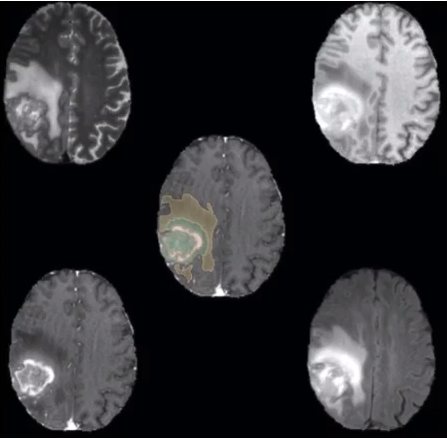

* 중앙 : t1에 mask입힌 영상, 빨간색 : ET, 초록색 : NET&NCR, 노락색 : ED
* 왼쪽 위 : T2, 오른쪽 위 : T1, 왼쪽 아래 : T1Gd, 오른쪽 아래 : FLAIR

In [ ]:
from pathlib import Path
from natsort import natsorted
from tqdm.notebook import tqdm
from IPython.display import display
from scipy import ndimage

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class cfg: 
    base_path = Path('/kaggle/input/brats20-dataset-training-validation/')
    train_path = base_path/'BraTS2020_TrainingData'/'MICCAI_BraTS2020_TrainingData'
    valid_path = base_path/'BraTS2020_ValidationData'/'MICCAI_BraTS2020_ValidationData'
    train_meta_csv   = train_path/'name_mapping.csv'
    train_survival_csv   = train_path/'survival_info.csv'
    
    valid_meta_csv   = valid_path/'name_mapping.csv'
    valid_survival_csv   = valid_path/'survival_info.csv'

### 1.1 Check & Counting data
* data의 위치 확인 및 갯수 확인은 필요하다.

In [ ]:
check_file = lambda x : x if x.is_file() else None

data_dict = {'Brats20ID':[], 'flair':[], 't1':[], 't1ce':[], 't2':[], 'mask':[]}
folder_pathes = natsorted(list(cfg.train_path.glob('*')))

data_dicts = []
for sample_path in tqdm(folder_pathes): 
    ## get images and labels
    flair_path = sample_path/str(sample_path.name+'_flair.nii')
    t1_path     = sample_path/str(sample_path.name+'_t1.nii')
    t1ce_path   = sample_path/str(sample_path.name+'_t1ce.nii')
    t2_path     = sample_path/str(sample_path.name+'_t2.nii')
    mask_path   = sample_path/str(sample_path.name+'_seg.nii')
    
    data_dict['Brats20ID'].append(sample_path.name)
    data_dict['flair'].append(check_file(flair_path))
    data_dict['t1'].append(check_file(t1_path))
    data_dict['t1ce'].append(check_file(t1ce_path))
    data_dict['t2'].append(check_file(t2_path))
    data_dict['mask'].append(check_file(mask_path))

df = pd.DataFrame(data_dict)

In [ ]:
df

In [ ]:
# check NAN value

df.isna().sum()
display(df.count())

In [ ]:
train = df.dropna().reset_index(drop=True)
display(train.count())

In [ ]:
sns.barplot(train.count().to_frame().T)

In [ ]:
train_survival_df = pd.read_csv(cfg.train_survival_csv)
merge_df = train.merge(train_survival_df, how='inner', on='Brats20ID')

* nifity파일을 읽어오기 위해서는 다양한 tool이 있습니다. 
* 대표적으로 Simple ITK & nibabel이 있는데요 
* 이 두개의 라이브러리를 비교해보고 또한 meta data추출까지 진행을 해보록 하겠습니다.

In [ ]:
import SimpleITK as sitk
import nibabel as nib

In [ ]:
all_data_path = merge_df[['flair','t1','t1ce','t2']].values # dataframe load하여 동일 이미지 추출

img = sitk.ReadImage(all_data_path[0][0])

In [ ]:
## nibabel version 

sample_img = nib.load(all_data_path[0][0])

name = all_data_path[0][0].name
sample_header = sample_img.header 
img = sample_img.get_fdata()

print(f'file name : {name}')
print(f'image shape : {sample_header .get_data_shape()}')
print(f'Pixel Spacing : {sample_header.get_zooms()}')
print(f'Data type: {sample_header.get_data_dtype()}')
print(f'Min, Max value : {np.min(img), np.max(img)}')
print('-----------------------------------------------------------')

# # ## nibabel version 
sample_img = sitk.ReadImage(all_data_path[0][0])
img = sitk.GetArrayFromImage(sample_img)
print(f'image shape : {sample_img.GetSize()}')
print(f'Pixel spacing : {sample_img.GetSpacing()}')
print(f'Data Type: {sample_img.GetPixelIDTypeAsString()}')
print(f'Min, Max value : {np.min(img), np.max(img)}')

In [ ]:
def extract_meta_data(sample_path, use_itk=True): 
    
    if use_itk: 
        sample_img = sitk.ReadImage(sample_path)
        img = sitk.GetArrayFromImage(sample_img)
        return np.min(img), np.max(img), sample_img.GetSize(), sample_img.GetSpacing()
    else: 
        sample_img = nib.load(sample_path)
        sample_header = sample_img.header
        img = sample_img.get_fdata()
        return np.min(img), np.max(img), sample_header.get_data_shape(), sample_header.get_zooms()

print(extract_meta_data(all_data_path[0][0]))

In [ ]:
merge_df

In [ ]:
meta_dict = {'flair_mima':[],'flair_shape':[],'flair_space':[],
             't1_mima':[],'t1_shape':[],'t1_space':[],
             't1ce_mima':[],'t1ce_shape':[],'t1ce_space':[],
             't2_mima':[],'t2_shape':[],'t2_space':[]}

for multi_modal_path in tqdm(all_data_path): 
    flair_path, t1_path, t1ce_path, t2_path = multi_modal_path
    result = [extract_meta_data(i) for i in multi_modal_path]    
    flair_meta, t1_meta, t1ce_meta, t2_meta = result 
    
    meta_dict['flair_mima'].append([flair_meta[0],flair_meta[1]])
    meta_dict['flair_shape'].append(flair_meta[2])
    meta_dict['flair_space'].append(flair_meta[3])
    
    meta_dict['t1_mima'].append([t1_meta[0],t1_meta[1]])
    meta_dict['t1_shape'].append(t1_meta[2])
    meta_dict['t1_space'].append(t1_meta[3])
    
    meta_dict['t1ce_mima'].append([t1ce_meta[0],t1ce_meta[1]])
    meta_dict['t1ce_shape'].append(t1ce_meta[2])
    meta_dict['t1ce_space'].append(t1ce_meta[3])
    
    meta_dict['t2_mima'].append([t2_meta[0],t2_meta[1]])
    meta_dict['t2_shape'].append(t2_meta[2])
    meta_dict['t2_space'].append(t2_meta[3])

In [ ]:
meta_df = pd.DataFrame(meta_dict)

In [ ]:
meta_df

* Check image의 Shape이 맞는지 확인해보며 shape의 형태도 맞는지 체크해본다.

In [ ]:
print(meta_df['flair_space'].unique())
print(meta_df['t1_space'].unique())
print(meta_df['t1ce_space'].unique())
print(meta_df['t2_space'].unique())

In [ ]:
print(meta_df['flair_shape'].unique())
print(meta_df['t1_shape'].unique())
print(meta_df['t1ce_shape'].unique())
print(meta_df['t2_shape'].unique())

In [ ]:
meta_df['flair_min'] = meta_df['flair_mima'].apply(lambda x : x[0])
meta_df['flair_max'] = meta_df['flair_mima'].apply(lambda x : x[1])

meta_df['t1_min'] = meta_df['t1_mima'].apply(lambda x : x[0])
meta_df['t1_max'] = meta_df['t1_mima'].apply(lambda x : x[1])

meta_df['t1ce_min'] = meta_df['t1ce_mima'].apply(lambda x : x[0])
meta_df['t1ce_max'] = meta_df['t1ce_mima'].apply(lambda x : x[1])

meta_df['t2_min'] = meta_df['t2_mima'].apply(lambda x : x[0])
meta_df['t2_max'] = meta_df['t2_mima'].apply(lambda x : x[1])

In [ ]:
meta_df.head()

In [ ]:
melt_df = meta_df.melt(id_vars='flair_mima', value_vars=['flair_max','t1_max','t1ce_max','t2_max'])
sns.histplot(data=melt_df, x='value',hue='variable', kde=True, element="step")

In [ ]:
melt_df = meta_df.melt(id_vars='flair_mima', value_vars=['flair_min','t1_min','t1ce_min','t2_min'])
sns.histplot(data=melt_df, x='value',hue='variable', kde=True, element="step", stat="density")

## 1.3 Mask annotation check 
* Check all mask has labels

In [ ]:
## reference : https://www.kaggle.com/code/mariuszwisniewski/brats2020-eda-and-data-visualization/notebook

from matplotlib import animation, cm, colors, rc
import matplotlib.patches as mpatches

DATA_TYPES = ['flair', 't1', 't1ce', 't2', 'mask']
MASK_LABELS = ['Non-Enhancing Tumor Core',
               'Peritumoral Edema', 'GD-Enhancing Tumor']
MASK_VALUES = [0, 1, 2, 4]
def cmap_discretize(cmap, N):
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1, ki],
                       colors_rgba[i, ki]) for i in range(N+1)]
    return colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)


rc('animation', html='jshtml')


def create_parallel_animation(volumes, case, show_mask=False, alpha=0.6):
    # transpose volume from (x, y, z) to (z, x, y)
    volumes = np.array([np.transpose(volume, (2, 0, 1)) for volume in volumes])
    fig = plt.figure(figsize=(12, 13))
    fig.tight_layout()
    plt.axis('off')
    plt.suptitle(f'Patient ID: {case}', fontsize=16, fontweight='bold')
    
    if show_mask: ## mask에 Color를 넣어준다. 
        custom_cmap = cmap_discretize(cm.jet, int(np.max(volumes[-1])) + 1)
        normalize = colors.Normalize(vmin=np.min(
            volumes[-1]), vmax=np.max(volumes[-1]))

    axes = []
    for idx, data_type in enumerate(DATA_TYPES[:-1]): # image에 넣을 figure를 만들어준다. 
        ax = fig.add_subplot(2, len(DATA_TYPES[:-1]) // 2, idx + 1)
        ax.set_title(data_type.upper(), weight='bold')
        axes.append(ax)

    images = []
    for i, slices in enumerate(zip(*volumes[:-1])): # 한장씩 loop를 돌면서 image를 쌓아준다. 
        aux_imgs = []
        for idx, s in enumerate(slices):
            im = axes[idx].imshow(s, animated=True, cmap='bone')
            aux_imgs.append(im)
            if show_mask:
                im2 = axes[idx].imshow(np.ma.masked_where(volumes[-1][i] == 0, volumes[-1][i]),
                                       animated=True, cmap=custom_cmap, alpha=alpha, interpolation='none')
                aux_imgs.append(im2)
        images.append(aux_imgs)

    if show_mask:
        print(np.unique(volumes[-1])[1:])
        patches = [mpatches.Patch(color=custom_cmap(normalize(col_val)),
                                  label=f'{MASK_LABELS[l_idx]}') for l_idx, col_val in enumerate(np.unique(volumes[-1])[1:])]
        plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(0.4, -0.1), borderaxespad=0.4,
                   title='Mask Labels', title_fontsize=18, edgecolor='black', facecolor='#c5c6c7')

    ani = animation.ArtistAnimation(
        fig, images, interval=5000 // len(images), blit=False, repeat_delay=1000
    )
    plt.close()
    return ani

In [ ]:
volumes = [nib.load(volume_path).get_fdata() for volume_path in merge_df[DATA_TYPES].loc[0].to_list()]
volumes = [ndimage.rotate(volume, -90, axes=(0,1), reshape=False, order=1) for volume in volumes]

create_parallel_animation(volumes, case='1', show_mask=False)

In [ ]:
create_parallel_animation(volumes, case='1', show_mask=True)

## 1.4 Image & mask visulization

In [ ]:
from monai.data import DataLoader, decollate_batch, Dataset
from scipy import ndimage
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Compose,
    NormalizeIntensityd
)
from monai.visualize.utils import (
    blend_images,## label과 Image를 합친 영상
    matshow3d ## 3d image의 visulization 
)

In [ ]:
data_dicts = []
for images_path, mask_path in zip(merge_df[['flair','t1','t1ce','t2']].values, merge_df['mask'].values):
    data_dicts.append({
            'image':images_path,
            'label':[mask_path]}
            )

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ])

In [ ]:
train_dataset = Dataset(data_dicts, transform=train_transform)

In [ ]:
print(f"image shape: {train_dataset[0]['image'].shape}")
print(f"label shape: {train_dataset[0]['label'].shape}")
print(f"pixel spacing: {train_dataset[0]['image'].pixdim}")
for img, title in zip(train_dataset[0]["image"], ['flair','t1','t1ce','t2']): 
    _ = matshow3d(
    volume=img[...,50::70],
    fig=None,
    title=title,
    frame_dim=-1,
    show=True,
    cmap="gray",)

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ])

In [ ]:
import matplotlib.pyplot as plt
import torch
for i in range(4): 
    if i != 4: 
        norm_img = train_dataset[0]["image"][[0]]/train_dataset[0]["image"].max()
        norm_lab = (train_dataset[0]["label"][None]==(i+1))*0.1
        ret = blend_images(image=norm_img, label=norm_lab, alpha=0.5, cmap="hsv", rescale_arrays=False)
        fig,axs = plt.subplots(1,3)
        slice_index = 70 
        axs[0].set_title(f"image slice {slice_index}")
        axs[0].imshow(train_dataset[0]["image"][0, :, :, slice_index], cmap="gray")
        axs[1].set_title(f"label slice {slice_index}")
        axs[1].imshow(train_dataset[0]["label"][:, :, slice_index])
        axs[2].set_title(f"blend slice {slice_index}")
        axs[2].imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))